In [1]:
from functools import partial
from json import dumps
import os
import pickle
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datasets
import sklearn.model_selection, sklearn.linear_model
import transformers
import torch
import tqdm
from tqdm.contrib.concurrent import process_map

import postprocess
import utils

split_ratio_for_test = 0.3
split_ratio_for_postprocessing = 0.5  # among all training data

# The seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 43)

# This seed controls the randomness during pre-training (fixed).
seed_for_pretraining = 33

max_workers = 32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

data_dir = "data/biasbios"

# BERT config
model_name = "bert-base-uncased"
batch_size = 128

transformers.set_seed(seed_for_pretraining)

## Download and embed BiasBios dataset

In [2]:
label_names = [
    "accountant", "architect", "attorney", "chiropractor", "comedian",
    "composer", "dentist", "dietitian", "dj", "filmmaker", "interior_designer",
    "journalist", "model", "nurse", "painter", "paralegal", "pastor",
    "personal_trainer", "photographer", "physician", "poet", "professor",
    "psychologist", "rapper", "software_engineer", "surgeon", "teacher",
    "yoga_teacher"
]
n_classes = len(label_names)

group_names = ["female", "male"]
n_groups = len(group_names)

features = datasets.Features({
    "bio": datasets.Value("string"),
    "title": datasets.ClassLabel(names=label_names),
    "gender": datasets.ClassLabel(names=group_names),
})

train_path = f"{data_dir}/train.pickle"
test_path = f"{data_dir}/test.pickle"
dev_path = f"{data_dir}/dev.pickle"
if any([not os.path.exists(p) for p in [train_path, test_path, dev_path]]):
  os.makedirs(data_dir, exist_ok=True)
  urllib.request.urlretrieve(
      "https://storage.googleapis.com/ai2i/nullspace/biasbios/train.pickle",
      train_path)
  urllib.request.urlretrieve(
      "https://storage.googleapis.com/ai2i/nullspace/biasbios/test.pickle",
      test_path)
  urllib.request.urlretrieve(
      "https://storage.googleapis.com/ai2i/nullspace/biasbios/dev.pickle",
      dev_path)

rows = {k: [] for k in features}
for split, path in zip(["train", "test", "dev"],
                       [train_path, test_path, dev_path]):
  with open(path, "rb") as pickle_file:
    for row in pickle.load(pickle_file):
      rows["gender"].append("female" if row["g"] == "f" else "male")
      rows["title"].append(row["p"])
      rows["bio"].append(rows["gender"][-1] + ". " +
                         row["hard_text_untokenized"])

raw_dataset = datasets.Dataset.from_dict(rows, features=features)
labels = np.array(raw_dataset["title"])
groups = np.array(raw_dataset["gender"])

print(dumps(raw_dataset[seed_for_pretraining], indent=2))

{
  "bio": "male. He produced scores of films including such as al-Dhareeh (the shrine), 1976, winner of the Cinema Institute Films\u2019 Award at the Documentary and Short Films Festival, Egypt, 1977; as well as the Kelibia Festival Award, Tunisia, 1978; al-Mahatta (The Station), winner of a major award at Oberhausen Short Film Festival, Germany, 1989; the EU Award at FESPACO Festival, Burkina Faso, 1990; The Silver Sword Award at Damascus festival, 1990; and The Silver Tanit Award, Carthage festival, Tunisia, 1991. Eltayeb has served as head of the Sudanese Film group for several terms and as secretary of the Sudanese Film club. He has written numerous articles on cinema, published in major Sudanese newspapers. He is currently working on a long fiction film, al-Siraj wal-attama (The Lantern and Darkness).",
  "title": 9,
  "gender": 1
}


In [3]:
# Compute and print dataset statistics

df = pd.DataFrame(
    np.stack(
        [
            np.array(group_names)[raw_dataset["gender"]],
            np.array(label_names)[raw_dataset["title"]]
        ],
        axis=1,
    ),
    columns=["Group", "Target"],
)
df_grouped = df.groupby(["Target", "Group"]).size().unstack()
counts = df_grouped.sum(axis=0)

print("Dataset statistics:")
display(df_grouped / counts)
display(pd.DataFrame(counts, columns=["Count"]).T)

print("Perfect results if dataset equals population:")
display(
    pd.DataFrame([{
        "alpha":
            np.inf,
        "accuracy":
            1.0,
        "delta_dp":
            utils.delta_dp(raw_dataset["title"], raw_dataset["gender"]),
        "delta_dp_rms":
            utils.delta_dp(
                raw_dataset["title"],
                raw_dataset["gender"],
                ord=2,
            ) / np.sqrt(n_classes)
    }, {
        "alpha":
            0.0,
        "accuracy":
            1 - postprocess.PostProcessorDP().fit(
                scores=np.concatenate(
                    [np.eye(n_classes) for _ in range(n_groups)], axis=0),
                groups=np.repeat(np.arange(n_groups), n_classes),
                sample_weight=np.nan_to_num(
                    (df_grouped.to_numpy() / counts.to_numpy())).T.flatten(),
            ).score_,
        "delta_dp":
            0.0,
        "delta_dp_rms":
            0.0
    }]).groupby('alpha').agg('mean').sort_index(ascending=False))

Dataset statistics:


Group,female,male
Target,,
accountant,0.011428,0.016898
architect,0.013168,0.036508
attorney,0.068610,0.095177
chiropractor,0.003789,0.009029
comedian,0.003251,0.010444
composer,0.005041,0.022156
dentist,0.028297,0.044132
dietitian,0.020258,0.001368
dj,0.001159,0.006029


Group,female,male
Count,182102,211321


Perfect results if dataset equals population:


,accuracy,delta_dp,delta_dp_rms
alpha,,,
inf,1.000000,0.08644,0.023733
0.0,0.884376,0.00000,0.000000


In [4]:
# Tokenize and embed the biographies using a pre-trained BERT

tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModel.from_pretrained(
    model_name, add_pooling_layer=True).to(device)
model_input_args = list(model.forward.__code__.co_varnames)


def tokenize_function(examples):
  tokenized_examples = tokenizer(
      examples["bio"],
      padding=False,
      max_length=tokenizer.model_max_length,
      truncation=True,
  )
  tokenized_examples["labels"] = examples["title"]
  tokenized_examples["group_labels"] = examples["gender"]
  return tokenized_examples


def embedding_fn(dataloader):
  model.eval()
  embeds = []
  with torch.no_grad():
    for batch in tqdm.tqdm(dataloader, desc="Inference"):
      batch = {
          k: v.to(device) for k, v in batch.items() if k in model_input_args
      }
      outputs = model(**batch, output_hidden_states=True)
      embeds.append(outputs.pooler_output.cpu().numpy())
  return np.concatenate(embeds, axis=0)


data_collator = transformers.DataCollatorWithPadding(tokenizer)
tokenized_dataset = raw_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=raw_dataset.column_names,
    desc="Running tokenizer on dataset",
)

dataloader = torch.utils.data.DataLoader(
    tokenized_dataset,
    collate_fn=data_collator,
    batch_size=batch_size,
)
embeds = embedding_fn(dataloader)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Running tokenizer on dataset:   0%|          | 0/393423 [00:00<?, ? examples/s]

Inference: 100%|████████████████████████████| 3074/3074 [16:40<00:00,  3.07it/s]


In [5]:
(embeds_, train_embeds_pre, labels_, train_labels_pre, groups_,
 train_groups_pre) = sklearn.model_selection.train_test_split(
     embeds,
     labels,
     groups,
     test_size=(1 - split_ratio_for_test) *
     (1 - split_ratio_for_postprocessing),
     random_state=seed_for_pretraining,
 )

n_samples = len(embeds)
n_test = int(n_samples * split_ratio_for_test)
n_post = n_samples - len(train_embeds_pre) - n_test

## Train score function

In [6]:
# Train a logistic regression model on the pre-training data
predictor = sklearn.linear_model.LogisticRegression(
  random_state=seed_for_pretraining, max_iter=10000)
predictor.fit(train_embeds_pre, train_labels_pre)
probas_ = predictor.predict_proba(embeds_)

## Post-process for demographic parity

  0%|          | 0/150 [00:00<?, ?it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.wa

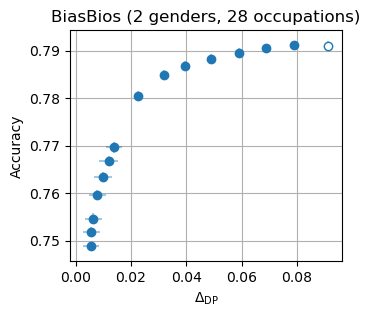

accuracy            delta_dp           delta_dp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.791053  0.000935  0.091219  0.000424     0.024309  0.000152
0.080  0.791141  0.000943  0.079039  0.001009     0.022879  0.000176
0.070  0.790581  0.000933  0.068912  0.001207     0.021775  0.000200
0.060  0.789568  0.000946  0.059195  0.001030     0.020802  0.000182
0.050  0.788248  0.000982  0.048995  0.001036     0.019904  0.000208
0.040  0.786861  0.000990  0.039409  0.000996     0.019172  0.000215
0.030  0.784885  0.001023  0.031790  0.000761     0.017329  0.000267
0.020  0.780526  0.001035  0.022559  0.001569     0.014168  0.000262
0.010  0.769610  0.001195  0.013831  0.002944     0.008091  0.000258
0.008  0.766785  0.001137  0.011899  0.003393     0.006782  0.000271
0.006  0.763483  0.001056  0.009927  0.003235     0.005404  0.000260
0.004  0.759611  0.001098  0.007914  0.003166     0.003994  0.000283
0.002  0.754650  0.001071  0.006325  0.003075     0.002546  0.000392
0.001  0.751813  0.001051  0.005667  0.003041     0.001949  0.000559
0.000  0.748792  0.000951  0.005583  0.003041     0.001666  0.000566

In [7]:
alphas = [
    np.inf, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.008, 0.006, 0.004,
    0.002, 0.001, 0.0
]

return_vals = process_map(
    partial(
        utils.postprocess,
        postprocessor_factory=postprocess.PostProcessorDP,
        evaluate_fn=partial(utils.evaluate,
                            n_groups=n_groups,
                            n_classes=n_classes,
                            metrics=['delta_dp', 'delta_dp_rms']),
        probas=probas_,
        labels=labels_,
        groups=groups_,
        n_post=n_post,
        n_test=n_test,
    ),
    [(alpha, seed) for alpha in alphas for seed in seeds],
    max_workers=max_workers,
)
results = [{
    'alpha': alpha,
    **result
} for alpha, _, result, _ in return_vals if result is not None]

(fig, ax), df = utils.plot_results(results, 'delta_dp')
ax.set_xlabel("$\\Delta_{\\mathrm{DP}}$")
ax.set_title("BiasBios (2 genders, 28 occupations)")
plt.show()
display(df)